## OGT phenotype

### 1. Read the initial datasets and visualize
#### 1.1. Read the test and train data

Number of samples = 3001, number of features = 3165
Number of categories = 50


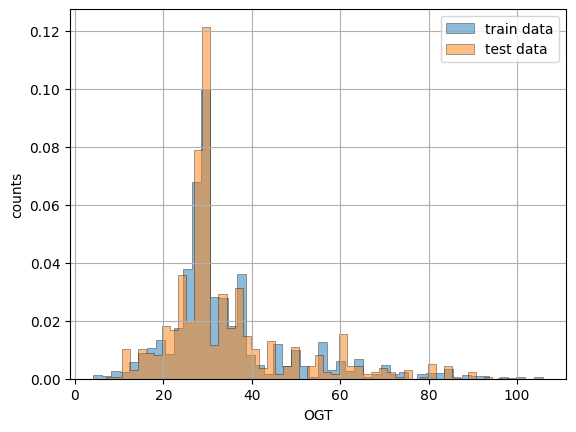

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import sys

# Add the parent directory to sys.path (to import util function)
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
    
#from set_transformer.main import read_ogt_data
from utils.utils import read_ogt_data

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 50 

ogt_continuous_flag = True
X_train, X_train_column_names, y_train, X_test, X_test_column_names, y_test, categories_linspace = read_ogt_data(device, num_classes, ogt_continuous_flag)


precence_only_flag = False
#X_train, X_train_column_names, y_train, X_test, X_test_column_names, y_test = read_ogt_data_custom_split(train_filename, test_filename, ogt_label_filename, device, precence_only_flag)
#X_train, y_train, X_test, y_test = X_train.cpu(), y_train.cpu(), X_test.cpu(), y_test.cpu()

print(f"Number of samples = {len(X_train)}, number of features = {len(X_train_column_names)}")
print(f"Number of categories = {num_classes}")

hist = plt.hist(y_train.cpu(), bins = 50, density = True, label = "train data", alpha = 0.5, histtype='stepfilled', edgecolor='black', linewidth=0.5)
hist = plt.hist(y_test.cpu(), bins = 50, density = True, label = "test data", alpha = 0.5, histtype='stepfilled', edgecolor='black', linewidth=0.5)
plt.xlabel("OGT")
plt.ylabel("counts")
plt.grid(True)
plt.legend();

#### 1.2. PCA and tSNE visualization of the training data (colors = temperature)

In [4]:
ogt_continuous_flag = True
precence_only_flag = False
X_train, X_train_column_names, y_train, X_test, X_test_column_names, y_test, categories_linspace = read_ogt_data(device, num_classes, ogt_continuous_flag)

Data after PCA reduction: (3001, 10)
Explained variance ratio: [0.0989486  0.06964376 0.06295433 0.05469485 0.0311636  0.02573935
 0.02182234 0.01539431 0.01329878 0.01251448]
Total explained variance: 0.4061743938220302
Shape of the projected data = (3001, 2)


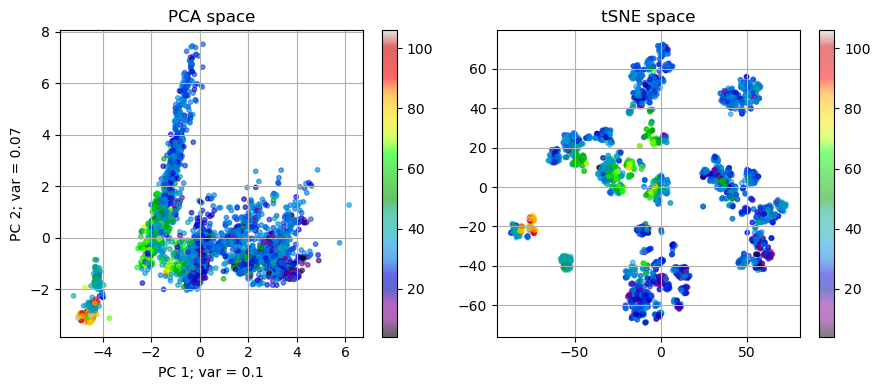

In [3]:
from utils.utils import pca_run_and_plot, tsne_plot

plt.figure(figsize=(9, 4))

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 10
pca_run_and_plot(X_train, n_compon, y_train);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X_train, y_train);

# Display the plots
plt.tight_layout()  
plt.show()

In [6]:
ogt_continuous_flag = True
precence_only_flag = True
X_train, X_train_column_names, y_train, X_test, X_test_column_names, y_test, categories_linspace = read_ogt_data(device, num_classes, ogt_continuous_flag, precence_only_flag)

Data after PCA reduction: (3001, 10)
Explained variance ratio: [0.10324972 0.07048592 0.06106351 0.05105075 0.02693612 0.02314346
 0.02024101 0.01382616 0.01280462 0.01194579]
Total explained variance: 0.3947470510272482
Shape of the projected data = (3001, 2)


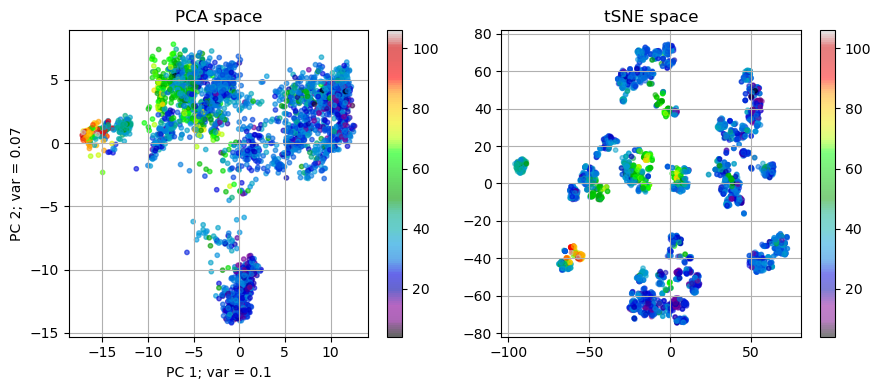

In [7]:
plt.figure(figsize=(9, 4))

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 10
pca_run_and_plot(X_train, n_compon, y_train);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X_train, y_train);

# Display the plots
plt.tight_layout()  
plt.show()

#### 2. SetTransformer

In this section, we plot the results for SetTransformers trained for the OGT data. In particular, we visualize the cross-validation predictions for different folds.

The results are visualized for a specified value of the number  of inducing points.

In [2]:
# Axillary function for reading the data 
def read_and_plot(filename, plot_flag=False):
    directory = "../results/SetTransformer/ogt/discrete_predict"
    df = pd.read_csv(f"{directory}/{filename}.csv",sep="\t")  # Replace with your file path
    
    y_act_to_temp = []
    for categ_i in df['y_actual']:
        mid_bin_temp = ((categories_linspace[categ_i-1] + categories_linspace[categ_i])/2)
        y_act_to_temp.append(mid_bin_temp)
    predict_to_temp = []
    for categ_i in df['prediction']:
        mid_bin_temp = ((categories_linspace[categ_i-1] + categories_linspace[categ_i])/2)
        predict_to_temp.append(mid_bin_temp)
    if plot_flag:
        plt.scatter(y_act_to_temp, predict_to_temp, marker='o', alpha = 0.3, c = "tab:blue", s=13)
    return min(y_act_to_temp), max(y_act_to_temp), min(predict_to_temp), max(predict_to_temp), y_act_to_temp, predict_to_temp

In [3]:
from matplotlib.colors import LogNorm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import pearsonr


# Specify the number of inducing points for plotting the results 
ind_point = 4
folds = range(5) # specify the fold range for data
file_names_cv = [f"prediction_probabilities_cross_valid_fold_{fold}_SetTransformer_indPoints_{ind_point}" for fold in folds]

# Read the actual OGT and the predicted classes + transform the classes to the temperature
y_act_to_temp_tot = []
predict_to_temp_tot = []
for file in file_names_cv:
    x_min, x_max, y_min, y_max, y_act_to_temp, predict_to_temp = read_and_plot(file, plot_flag=False)
    y_act_to_temp_tot += y_act_to_temp
    predict_to_temp_tot += predict_to_temp

In [39]:
# Calculate R^2 and pearson correlation coefficient
r2 = r2_score(y_act_to_temp_tot, predict_to_temp_tot)
print(f"R^2 = {round(r2,2)}")

pcc_scipy, p_value = pearsonr(y_act_to_temp_tot, predict_to_temp_tot)
print(f"PCC = {round(pcc_scipy,2)}")

R^2 = 0.54
PCC = 0.8


In [40]:
# Fit a linear regression model
model = LinearRegression()

x = np.array(y_act_to_temp_tot).reshape(-1, 1)
y = np.array(predict_to_temp_tot)
model.fit(x, y)

# Get predictions for the best-fit line
y_pred = model.predict(x)

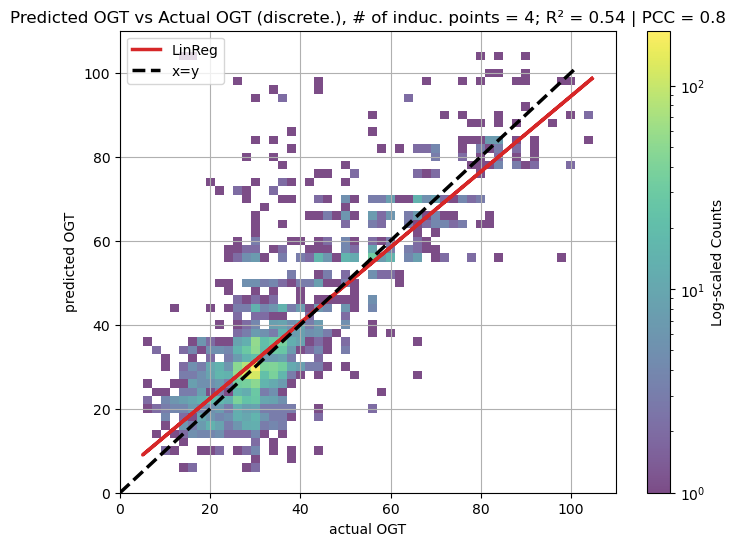

In [41]:
# Create the figure
plt.figure(figsize=(8, 6))
plt.grid(True)

# Plot the best-fit line
plt.plot(x, y_pred, color='tab:red', linewidth=2.5, label=f'LinReg')

# Create a 2D histogram with log scaling for counts
hist = plt.hist2d(
    y_act_to_temp_tot,
    predict_to_temp_tot,
    bins=num_classes,
    norm=LogNorm(),
    cmap='viridis', alpha = 0.7
)
plt.plot([0,x_max],[0,x_max], c = "black", label = "x=y", linestyle='--', linewidth=2.5)
plt.xlim([0,110])
plt.ylim([0,110])

# Add a color bar with the label
cbar = plt.colorbar(hist[3], label="Log-scaled Counts")

# Add labels and a title
plt.title(f'Predicted OGT vs Actual OGT (discrete.), # of induc. points = {ind_point}; R² = {round(r2,2)} | PCC = {round(pcc_scipy,2)}')
plt.xlabel('actual OGT')
plt.ylabel('predicted OGT')
plt.legend()
# Show the plot
plt.show()

##### 3. Plot the model accuracy as the function of the number of inducing points

(0.4, 0.8)

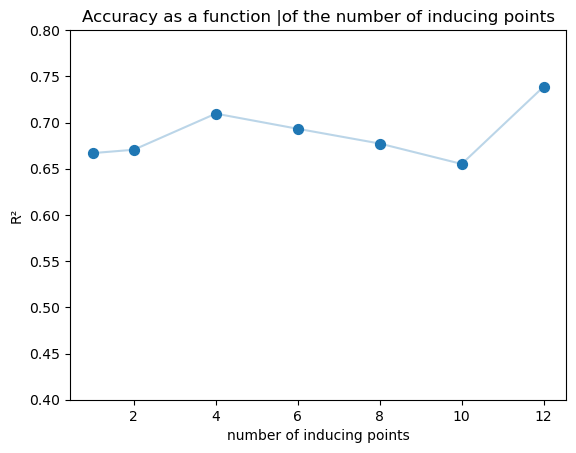

In [87]:
num_ind_arr = [1, 2, 4, 6, 8, 10, 12]#, 6, 8, 10, 12, 14, 16, 18, 20]#[1, 2, 4, 6, 8, 10, 12, 14, 16, 18]
r2_arr = []

file_names_cv_arr = []
for ind_point in num_ind_arr:
    file_names_cv = [f"prediction_probabilities_cross_valid_fold_0_SetTransformer_indPoints_{ind_point}", f"prediction_probabilities_cross_valid_fold_1_SetTransformer_indPoints_{ind_point}", f"prediction_probabilities_cross_valid_fold_2_SetTransformer_indPoints_{ind_point}", f"prediction_probabilities_cross_valid_fold_3_SetTransformer_indPoints_{ind_point}", f"prediction_probabilities_cross_valid_fold_4_SetTransformer_indPoints_{ind_point}"]
    y_act_to_temp_tot = []
    predict_to_temp_tot = []
    for file in file_names_cv:
        x_min, x_max, y_min, y_max, y_act_to_temp, predict_to_temp = read_and_plot(file)
        y_act_to_temp_tot += y_act_to_temp
        predict_to_temp_tot += predict_to_temp
    r2 = r2_score(y_act_to_temp_tot, predict_to_temp_tot)
    r2_arr.append(r2)

plt.figure()
plt.scatter(num_ind_arr, r2_arr, s=50)
plt.plot(num_ind_arr, r2_arr, alpha = 0.3)
plt.xlabel("number of inducing points")
plt.ylabel("R²")
plt.title("Accuracy as a function |of the number of inducing points")
plt.ylim([0.4,0.8])

Text(0.5, 1.0, 'Predicted OGT vs Actual OGT (contin.), # of induc. points = 4; MSE = 38.43; RMSE = 6.2')

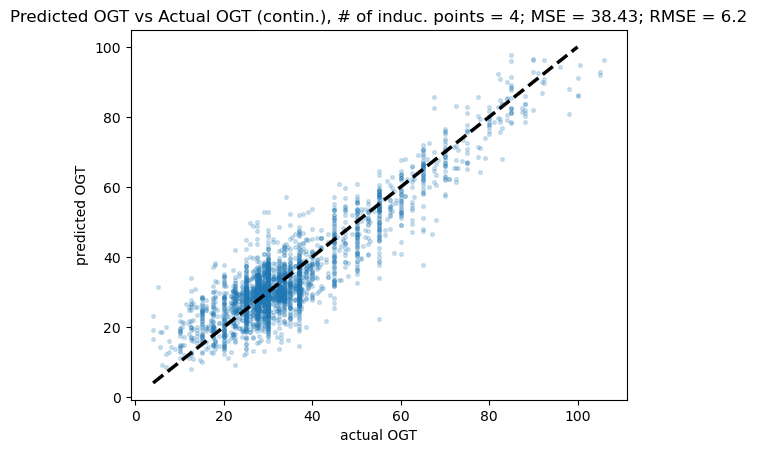

In [45]:
# Specify the number of inducing points for plotting the results 
ind_point = 4
folds = range(5) # specify the fold range for data
file_names_cv = [f"prediction_probabilities_cross_valid_fold_{fold}_SetTransformer_indPoints_{ind_point}" for fold in folds]


directory = "../results/SetTransformer/ogt/continuous_predict"

y_actual_total = []
y_predict_total = []
for filename in file_names_cv:
    df = pd.read_csv(f"{directory}/{filename}.csv",sep="\t") 
    y_actual = df["y_actual"].tolist()
    y_predict = df["prediction"].tolist()
    
    y_actual_total += y_actual
    y_predict_total += y_predict

mse = np.mean((np.array(y_actual_total) - np.array(y_predict_total)) ** 2)
    
plt.scatter(y_actual_total, y_predict_total, marker='o', alpha = 0.2, c = "tab:blue", s=7)
plt.plot([4,100],[4,100], c = "black", label = "x=y", linestyle='--', linewidth=2.5)    
plt.xlabel('actual OGT')
plt.ylabel('predicted OGT')    
plt.title(f'Predicted OGT vs Actual OGT (contin.), # of induc. points = {ind_point}; MSE = {round(mse,2)}; RMSE = {round(np.sqrt(mse),2)}')

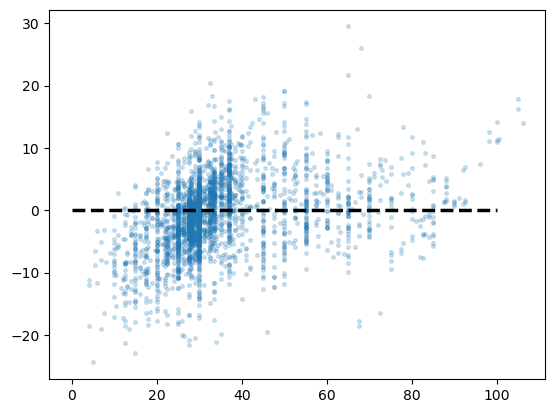

In [77]:
diff = []
for i in range(len(y_actual_total)):
    diff.append(y_actual_total[i] -  y_predict_total[i])
plt.scatter(y_actual_total, diff, marker='o', alpha = 0.2, c = "tab:blue", s=7)    
plt.plot([0,100],[0,0], c = "black", label = "x=y", linestyle='--', linewidth=2.5)    

(25.0, 50.0)

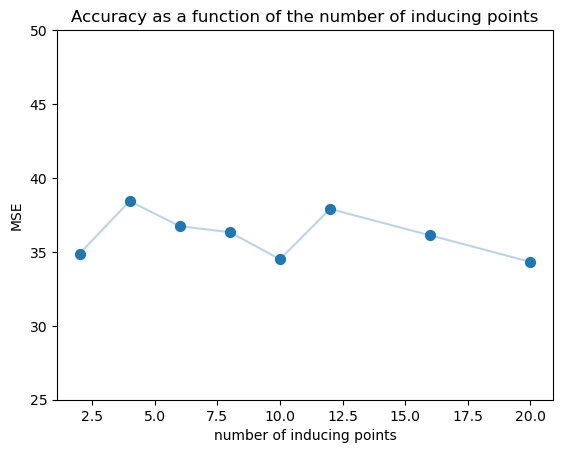

In [48]:
num_ind_arr = [2, 4, 6, 8, 10, 12, 16, 20]#[1, 2, 4, 6, 8, 10, 12, 14, 16, 18]
mse_arr = []
folds = range(5)
directory = "../results/SetTransformer/ogt/continuous_predict"

file_names_cv_arr = []
for ind_point in num_ind_arr:
    file_names_cv = [f"prediction_probabilities_cross_valid_fold_{fold}_SetTransformer_indPoints_{ind_point}" for fold in folds]
  #  print(file_names_cv)
    y_actual_total = []
    y_predict_total = []
    for file in file_names_cv:
        #print(f"{directory}/{file}.csv")
        df = pd.read_csv(f"{directory}/{file}.csv",sep="\t") 
       # print(df)
        y_actual = df["y_actual"].tolist()
        y_predict = df["prediction"].tolist()
        
        y_actual_total += y_actual
        y_predict_total += y_predict
    mse = np.mean((np.array(y_actual_total) - np.array(y_predict_total)) ** 2)
    mse_arr.append(mse)

plt.figure()
plt.scatter(num_ind_arr, mse_arr, s=50)
plt.plot(num_ind_arr, mse_arr, alpha = 0.3)
plt.xlabel("number of inducing points")
plt.ylabel("MSE")
plt.title("Accuracy as a function of the number of inducing points")
plt.ylim([25,50])

#### 2. XGBoost: classification


In [6]:
import numpy as np
import matplotlib.pyplot as plt

import xgboost
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

from sklearn.feature_selection import mutual_info_classif

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

In [14]:
#Add XGBoost
ogt_continuous_flag = False
num_classes = 30
X_train, X_train_column_names, y_train, X_test, X_test_column_names, y_test, categories_linspace = read_ogt_data(device, num_classes, ogt_continuous_flag)

print(np.unique(y_train.cpu().numpy()))
print(len(np.unique(y_train.cpu().numpy())))
print(np.unique(y_test.cpu().numpy()))

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29.]
30
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27.]


In [15]:
from sklearn.model_selection import cross_val_predict, KFold
from xgboost import XGBRegressor


num_classes = len(np.unique(y_train.cpu().numpy().astype(int)))

model = XGBClassifier(
    n_jobs=-1,                # Use all CPU cores
    tree_method="hist",   # Use "hist" for CPU, "gpu_hist" for GPU
    objective="multi:softmax",  # Default loss function for regression
    #n_estimators=35,
    num_class = num_classes,
)

from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold

kf  = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=42)

y_true_list = []
y_pred_list = []

y_train_int = y_train.cpu().numpy().astype(int) 

for train_idx, test_idx in kf.split(X_train, y_train_int):
    y_fold_train = y_train[train_idx]
    print("Unique classes in this fold:", np.unique(y_fold_train))
    
    X_fold_train, X_fold_test = X_train[train_idx], X_train[test_idx]
    y_fold_train, y_fold_test = y_train[train_idx], y_train[test_idx]

    model.fit(X_fold_train, y_fold_train.numpy().astype(int))
    y_pred_fold = model.predict(X_fold_test)

    y_true_list.append(y_fold_test)
    y_pred_list.append(y_pred_fold)

# Convert lists to arrays
y_true = np.concatenate(y_true_list)
y_pred = np.concatenate(y_pred_list)

print(len(y_true))
print(len(y_pred))

# Evaluate using RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"RMSE: {rmse:.2f}")

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Unique classes in this fold: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29.]
Unique classes in this fold: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29.]
Unique classes in this fold: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29.]
Unique classes in this fold: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29.]
Unique classes in this fold: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29.]
3001
3001
RMSE: 2.14


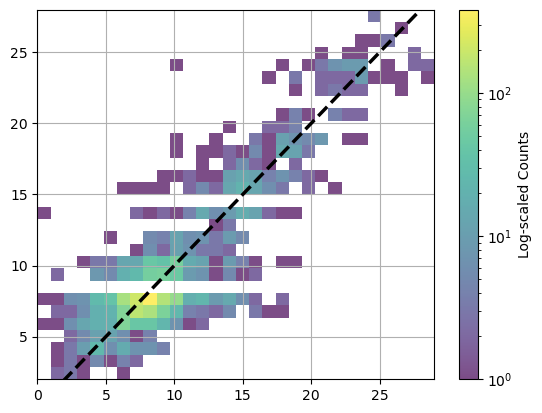

In [20]:
# Create a 2D histogram with log scaling for counts
hist = plt.hist2d(
    y_true,
    y_pred,
    bins=num_classes,
    norm=LogNorm(),
    cmap='viridis', alpha = 0.7
)
x_max=30
plt.plot([0,x_max],[0,x_max], c = "black", label = "x=y", linestyle='--', linewidth=2.5)
plt.grid(True)
#plt.xlim([0,110])
#plt.ylim([0,110])

# Add a color bar with the label
cbar = plt.colorbar(hist[3], label="Log-scaled Counts")

In [84]:
train_accuracy = accuracy_score(y_train.cpu(), model.predict(X_train.cpu()))
test_accuracy = accuracy_score(y_test.cpu(), model.predict(X_test.cpu()))
print(f"train_accuracy = {train_accuracy}; test_accuracy = {test_accuracy}")

train_accuracy = 0.9300233255581473; test_accuracy = 0.5818908122503329


In [8]:
model.fit(X_train.cpu(), y_train.cpu().numpy())
y_pred = model.predict(X_test.cpu()) 

#### 2. XGBoost: regression

In [3]:
from utils.utils import train_xgboost
from sklearn.metrics import mean_squared_error,r2_score

ogt_continuous_flag = True

C:\Users\kolda\AppData\Local\Programs\Python\Python312\Lib\site-packages\cupy\_environment.py:217: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


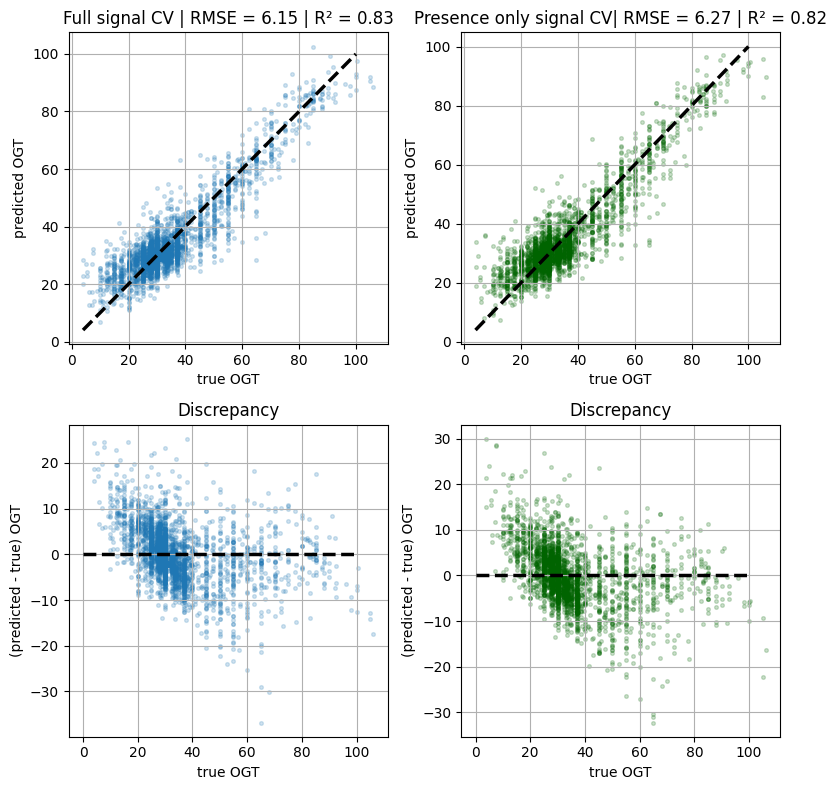

In [4]:
plt.figure(figsize=(8, 8))

# Full signal
plt.subplot(2, 2, 1) 
precence_only_flag = False
X_train, X_train_column_names, y_train, X_test, X_test_column_names, y_test, categories_linspace = read_ogt_data(device, num_classes, ogt_continuous_flag, precence_only_flag)
#X_train, X_train_column_names, y_train, X_test, X_test_column_names, y_test = read_ogt_data_custom_split(train_filename, test_filename, ogt_label_filename, device, precence_only_flag)
X_train, y_train, X_test, y_test = X_train.cpu(), y_train.cpu(), X_test.cpu(), y_test.cpu()
y_true_cv, y_pred_cv, y_pred_test = train_xgboost(X_train.cpu(), y_train.cpu(), X_test.cpu(), y_test.cpu())
rmse = np.sqrt(mean_squared_error(y_true_cv, y_pred_cv))
r2 = r2_score(y_true_cv, y_pred_cv)
plt.scatter(y_true_cv, y_pred_cv, marker='o', alpha = 0.2, c = "tab:blue", s=7)
plt.plot([4,100],[4,100], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"Full signal CV | RMSE = {rmse:.2f} | R² = {r2:.2f}")
plt.grid(True)

# Diff for full signal
plt.subplot(2, 2, 3) 
diff = [y_pred_cv[i] - y_true_cv[i] for i in range(len(y_true_cv))]
plt.scatter(y_true_cv, diff, marker='o', alpha = 0.2, c = "tab:blue", s=7, facecolor='none')    
plt.plot([0,100],[0,0], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title("Discrepancy")
plt.grid(True)

# Presence only signal
plt.subplot(2, 2, 2) 
precence_only_flag = True
X_train, X_train_column_names, y_train, X_test, X_test_column_names, y_test, categories_linspace = read_ogt_data(device, num_classes, ogt_continuous_flag, precence_only_flag)
#X_train, X_train_column_names, y_train, X_test, X_test_column_names, y_test = read_ogt_data_custom_split(train_filename, test_filename, ogt_label_filename, device, precence_only_flag)
X_train, y_train, X_test, y_test = X_train.cpu(), y_train.cpu(), X_test.cpu(), y_test.cpu()
y_true_cv, y_pred_cv, y_pred_test = train_xgboost(X_train.cpu(), y_train.cpu(), X_test.cpu(), y_test.cpu())
rmse = np.sqrt(mean_squared_error(y_true_cv, y_pred_cv))
r2 = r2_score(y_true_cv, y_pred_cv)
plt.scatter(y_true_cv, y_pred_cv, marker='o', alpha = 0.2, c = "darkgreen", s=7)
plt.plot([4,100],[4,100], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"Presence only signal CV| RMSE = {rmse:.2f} | R² = {r2:.2f}")
plt.grid(True)

# Diff for presence only signal
plt.subplot(2, 2, 4) 
diff = [y_pred_cv[i] - y_true_cv[i] for i in range(len(y_true_cv))]
plt.scatter(y_true_cv, diff, marker='o', alpha = 0.2, c = "darkgreen", s=7, facecolor='none')    
plt.plot([0,100],[0,0], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title("Discrepancy")
plt.grid(True)

# Display the plots
plt.tight_layout()  
plt.show()

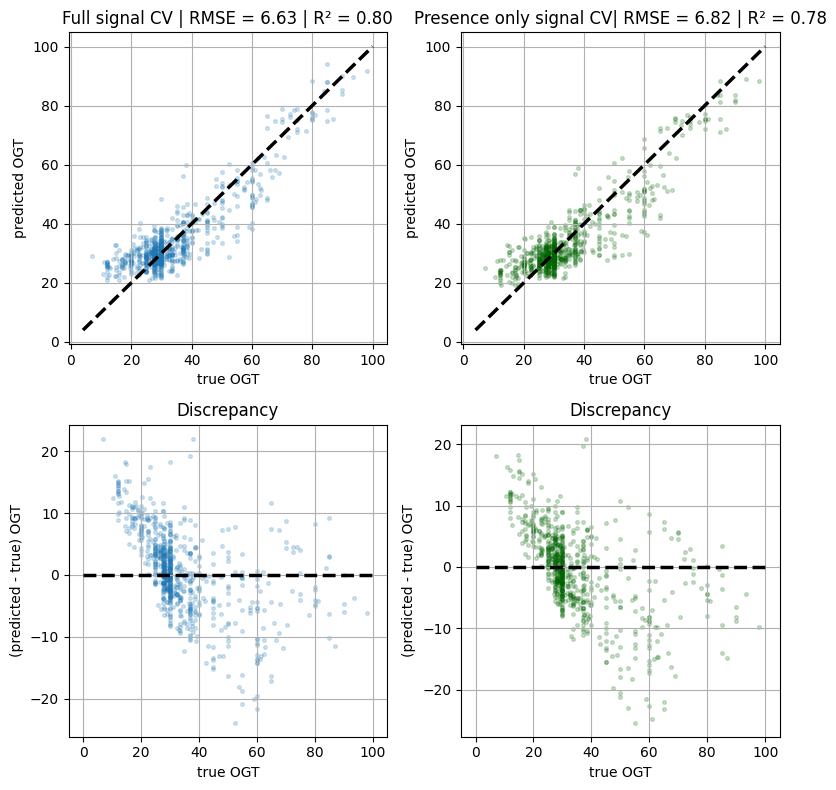

In [5]:
plt.figure(figsize=(8, 8))

# Full signal
plt.subplot(2, 2, 1) 
precence_only_flag = False
X_train, X_train_column_names, y_train, X_test, X_test_column_names, y_test, categories_linspace = read_ogt_data(device, num_classes, ogt_continuous_flag, precence_only_flag)
#X_train, X_train_column_names, y_train, X_test, X_test_column_names, y_test = read_ogt_data_custom_split(train_filename, test_filename, ogt_label_filename, device, precence_only_flag)
X_train, y_train, X_test, y_test = X_train.cpu(), y_train.cpu(), X_test.cpu(), y_test.cpu()
y_true_cv, y_pred_cv, y_pred_test = train_xgboost(X_train, y_train, X_test, y_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2 = r2_score(y_test, y_pred_test)
plt.scatter(y_test, y_pred_test, marker='o', alpha = 0.2, c = "tab:blue", s=7)
plt.plot([4,100],[4,100], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"Full signal CV | RMSE = {rmse:.2f} | R² = {r2:.2f}")
plt.grid(True)

# Diff for full signal  
plt.subplot(2, 2, 3) 
diff = [y_pred_test[i] - y_test[i] for i in range(len(y_pred_test))]
plt.scatter(y_test, diff, marker='o', alpha = 0.2, c = "tab:blue", s=7, facecolor='none')    
plt.plot([0,100],[0,0], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title("Discrepancy")
plt.grid(True)

# Presence only signal
plt.subplot(2, 2, 2) 
precence_only_flag = True
X_train, X_train_column_names, y_train, X_test, X_test_column_names, y_test, categories_linspace = read_ogt_data(device, num_classes, ogt_continuous_flag, precence_only_flag)
#X_train, X_train_column_names, y_train, X_test, X_test_column_names, y_test = read_ogt_data_custom_split(train_filename, test_filename, ogt_label_filename, device, precence_only_flag)
X_train, y_train, X_test, y_test = X_train.cpu(), y_train.cpu(), X_test.cpu(), y_test.cpu()
y_true_cv, y_pred_cv, y_pred_test = train_xgboost(X_train, y_train, X_test, y_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2 = r2_score(y_test, y_pred_test)
plt.scatter(y_test, y_pred_test, marker='o', alpha = 0.2, c = "darkgreen", s=7)
plt.plot([4,100],[4,100], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"Presence only signal CV| RMSE = {rmse:.2f} | R² = {r2:.2f}")
plt.grid(True)

# Diff for presence only signal
plt.subplot(2, 2, 4) 
diff = [y_pred_test[i] - y_test[i] for i in range(len(y_pred_test))]
plt.scatter(y_test, diff, marker='o', alpha = 0.2, c = "darkgreen", s=7, facecolor='none')    
plt.plot([0,100],[0,0], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title("Discrepancy")
plt.grid(True)

# Display the plots
plt.tight_layout()  
plt.show()

### 2. Feature selection

#### 2.1. Feature space

In [6]:
precence_only_flag = False
ogt_continuous_flag = True
X_train, X_train_column_names, y_train, X_test, X_test_column_names, y_test, categories_linspace = read_ogt_data(device, num_classes, ogt_continuous_flag, precence_only_flag)
#X_train, X_train_column_names, y_train, X_test, X_test_column_names, y_test = read_ogt_data_custom_split(train_filename, test_filename, ogt_label_filename, device, precence_only_flag)
X_train, y_train, X_test, y_test = X_train.cpu(), y_train.cpu(), X_test.cpu(), y_test.cpu()

X_train_np = np.array(X_train)
X_train_transposed = X_train_np.T
print(f"X_train_transposed shape = {X_train_transposed.shape}")

X_train_transposed shape = (3165, 3001)


Data after PCA reduction: (3165, 10)
Explained variance ratio: [0.28256226 0.07351965 0.04577311 0.04043311 0.03102705 0.01954615
 0.01671802 0.01633036 0.01282013 0.01267544]
Total explained variance: 0.5514052705839276
Shape of the projected data = (3165, 2)


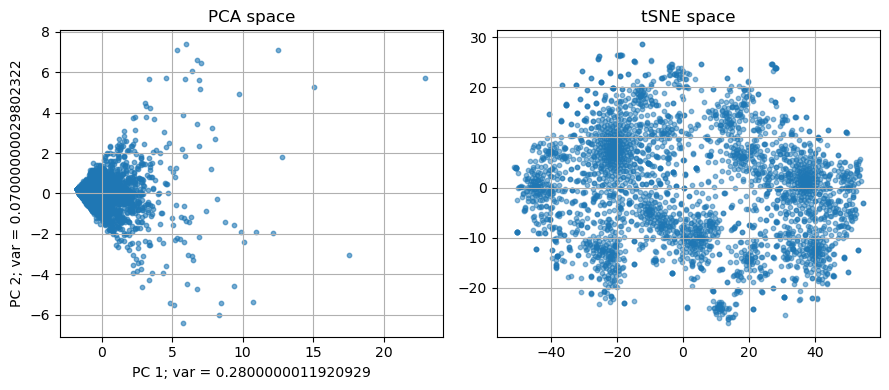

In [7]:
from utils.utils import pca_run_and_plot, tsne_plot

plt.figure(figsize=(9, 4))

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 10
pca_run_and_plot(X_train_transposed, n_compon);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X_train_transposed);

# Display the plots
plt.tight_layout()  
plt.show()

#### 2.1. Mutual Information

In [7]:
from feature_selection.feature_selection_utils import mutual_info_features

precence_only_flag = True
ogt_continuous_flag = True
X_train, X_train_column_names, y_train, X_test, X_test_column_names, y_test, categories_linspace = read_ogt_data(device, num_classes, ogt_continuous_flag, precence_only_flag)
X_train, y_train, X_test, y_test = X_train.cpu(), y_train.cpu(), X_test.cpu(), y_test.cpu()
sorted_cog_idx_by_mi, sorted_mi, sorted_names = mutual_info_features(X_train, y_train, X_train_column_names, contin_flag = True)

In [8]:
# Select the top N features
N = 30
top_N_indices = sorted_cog_idx_by_mi[:N]
top_N_mi = sorted_mi[:N]
top_N_names_by_mi = sorted_names[:N]
top_feat_mi_counts = [X_train_transposed[i] for i in sorted_cog_idx_by_mi[:N]]

print(len(top_feat_mi_counts[0]))

print(f"Top {N} COGs:", top_N_names_by_mi)

3001
Top 30 COGs: ['K03654', 'K03648', 'K00164', 'K06207', 'K06158', 'K19091', 'K00831', 'K06911', 'K07464', 'K19784', 'K10804', 'K02837', 'K03321', 'K06891', 'K08234', 'K00684', 'K06990', 'K07735', 'K07304', 'K16568', 'K07305', 'K03575', 'K01246', 'K00627', 'K08296', 'K02122', 'K03781', 'K00275', 'K15977', 'K01142']


Data after PCA reduction: (3001, 10)
Explained variance ratio: [0.33963507 0.07954334 0.06679538 0.05037903 0.04082193 0.0366629
 0.03315599 0.02888628 0.02691456 0.02613771]
Total explained variance: 0.7289322055876255
Shape of the projected data = (3001, 2)


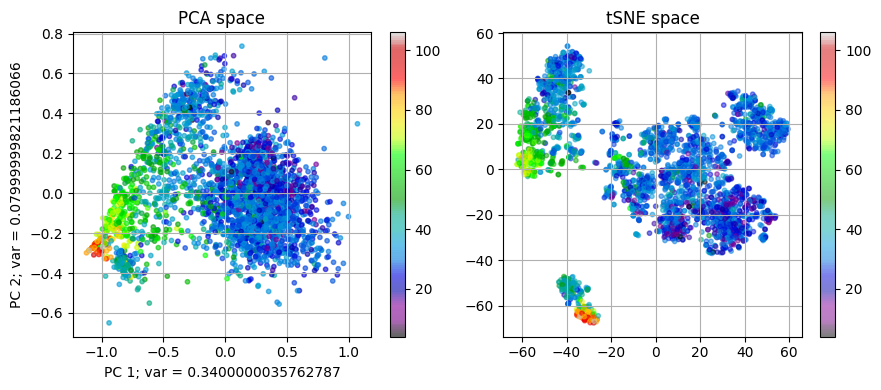

In [10]:
from utils.utils import pca_run_and_plot, tsne_plot

plt.figure(figsize=(9, 4))

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 10
pca_run_and_plot(np.array(top_feat_mi_counts).T, n_compon, y_train);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(np.array(top_feat_mi_counts).T, y_train);

# Display the plots
plt.tight_layout()  
plt.show()

In [10]:
from utils.utils import train_xgboost
from sklearn.metrics import mean_squared_error,r2_score
from feature_selection.feature_selection_utils import xgboost_train_accur, xgboost_accur_select_features
from sklearn.preprocessing import MaxAbsScaler

scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train.cpu())
X_test_scaled = scaler.fit_transform(X_test.cpu())

y_train, y_test = y_train.cpu(), y_test.cpu()
y_true_cv, y_pred_cv, y_pred_test  = train_xgboost(X_train.cpu(), y_train, X_test.cpu(), y_test) 

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)

rmse_cv = np.sqrt(mean_squared_error(y_true_cv, y_pred_cv))
r2_cv = r2_score(y_true_cv, y_pred_cv)

print(f"XGBoost baseline test RMSE (all features) = {rmse_test:.2f}, R2 = {r2_test:.2f}")
print(f"XGBoost baseline CV RMSE (all features) = {rmse_cv:.2f}, R2 = {r2_cv:.2f}")

XGBoost baseline test RMSE (all features) = 6.82, R2 = 0.78
XGBoost baseline CV RMSE (all features) = 6.27, R2 = 0.82


In [12]:
from utils.utils import xgboost_accuracy_contin   


feat_step = 5
feat_removal = False
rmse_test_arr_mi, r2_test_arr_mi, rmse_cv_arr_mi, r2_cv_arr_mi, num_feat_plot   = xgboost_accuracy_contin(X_train_scaled, X_test_scaled, y_train, y_test, sorted_cog_idx_by_mi, feat_step, feat_removal)

In [13]:
feat_removal = True
rmse_test_arr_mi_rem, r2_test_arr_mi_rem, rmse_cv_arr_mi_rem, r2_cv_arr_mi_rem, num_feat_plot_rem   = xgboost_accuracy_contin(X_train, X_test, y_train, y_test, sorted_cog_idx_by_mi, feat_step, feat_removal)

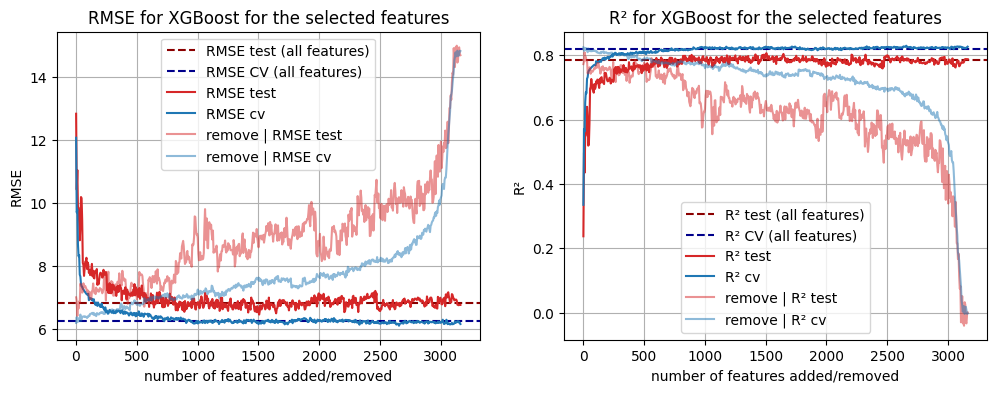

In [14]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.axhline(y=rmse_test, color='darkred', linestyle='--', linewidth=1.5, label='RMSE test (all features)')
plt.axhline(y=rmse_cv, color='darkblue', linestyle='--', linewidth=1.5, label='RMSE CV (all features)')
plt.plot(num_feat_plot, rmse_test_arr_mi, c = "tab:red", label = "RMSE test")
plt.plot(num_feat_plot, rmse_cv_arr_mi, c = "tab:blue", label = "RMSE cv")

plt.plot(num_feat_plot_rem, rmse_test_arr_mi_rem, c = "tab:red", label = "remove | RMSE test", alpha = 0.5)
plt.plot(num_feat_plot_rem, rmse_cv_arr_mi_rem, c = "tab:blue", label = "remove | RMSE cv", alpha = 0.5)

plt.xlabel("number of features added/removed")
plt.ylabel("RMSE")
plt.title("RMSE for XGBoost for the selected features")
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.axhline(y=r2_test, color='darkred', linestyle='--', linewidth=1.5, label='R² test (all features)')
plt.axhline(y=r2_cv, color='darkblue', linestyle='--', linewidth=1.5, label='R² CV (all features)')
plt.plot(num_feat_plot, r2_test_arr_mi, c = "tab:red", label = "R² test")
plt.plot(num_feat_plot, r2_cv_arr_mi, c = "tab:blue", label = "R² cv")

plt.plot(num_feat_plot_rem, r2_test_arr_mi_rem, c = "tab:red", label = "remove | R² test", alpha = 0.5)
plt.plot(num_feat_plot_rem, r2_cv_arr_mi_rem, c = "tab:blue", label = "remove | R² cv", alpha = 0.5)

plt.xlabel("number of features added/removed")
plt.ylabel("R²")
plt.title("R² for XGBoost for the selected features")
plt.grid()
plt.legend()

plt.show()

#### 2.2. Random Forest

Feature importances: [3.17112387e-04 1.46869758e-03 6.84746983e-05 ... 1.39164332e-04
 2.76681995e-04 2.07700035e-07]
3165
Original feature count: 3165, Selected feature count: 165


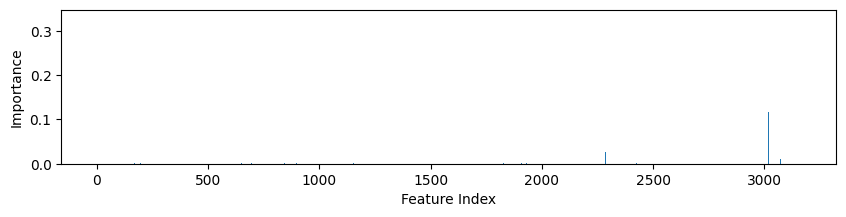

In [18]:
from feature_selection.feature_selection_utils import random_forest_features

precence_only_flag = True
ogt_continuous_flag = True
X_train, X_train_column_names, y_train, X_test, X_test_column_names, y_test, categories_linspace = read_ogt_data(device, num_classes, ogt_continuous_flag, precence_only_flag)
X_train, y_train, X_test, y_test = X_train.cpu(), y_train.cpu(), X_test.cpu(), y_test.cpu()
sorted_cog_idx_by_rand_forest, sorted_importances, sorted_names = random_forest_features(X_train, y_train, X_train_column_names, contin_flag = True)

In [19]:
# Select the top N features
N = 30
top_N_indices = sorted_cog_idx_by_rand_forest[:N]
top_N_importances = sorted_importances[:N]
top_N_names_by_rand_forest = sorted_names[:N]
top_feat_rand_forest_counts = [X_train_transposed[i] for i in sorted_cog_idx_by_rand_forest[:N]]
print(f"Top {N} COGs:", top_N_names_by_rand_forest)

Top 30 COGs: ['K06207', 'K03170', 'K06158', 'K06970', 'K06416', 'K03654', 'K06168', 'K02837', 'K07304', 'K06390', 'K19091', 'K04043', 'K07464', 'K19139', 'K03321', 'K07137', 'K08997', 'K19138', 'K03648', 'K00773', 'K18682', 'K02234', 'K15314', 'K03781', 'K03724', 'K16568', 'K14441', 'K19140', 'K02357', 'K07816']


Data after PCA reduction: (3001, 10)
Explained variance ratio: [0.23627222 0.10267197 0.094072   0.06759902 0.06285465 0.04447592
 0.04027211 0.03514565 0.03314092 0.02929484]
Total explained variance: 0.7457992862910032
Shape of the projected data = (3001, 2)


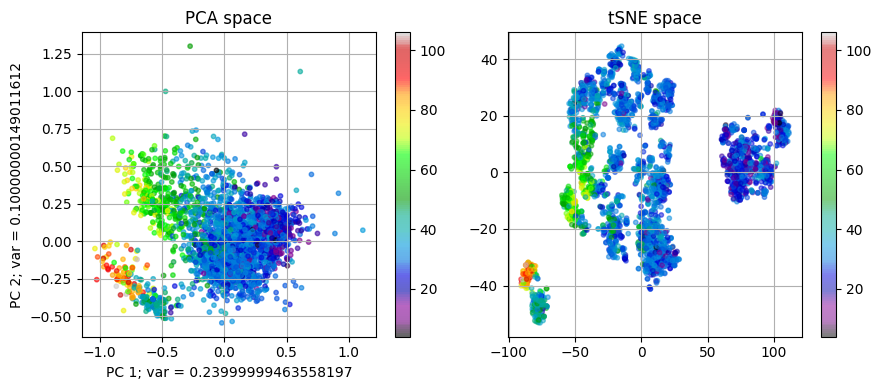

In [20]:
from utils.utils import pca_run_and_plot, tsne_plot

plt.figure(figsize=(9, 4))

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 10
pca_run_and_plot(np.array(top_feat_rand_forest_counts).T, n_compon, y_train);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(np.array(top_feat_rand_forest_counts).T, y_train);

# Display the plots
plt.tight_layout()  
plt.show()

In [21]:
from utils.utils import xgboost_accuracy_contin   

feat_step = 5
feat_removal = False
rmse_test_arr_randfor, r2_test_arr_randfor, rmse_cv_arr_randfor, r2_cv_arr_randfor, num_feat_plot   = xgboost_accuracy_contin(X_train, X_test, y_train, y_test, sorted_cog_idx_by_rand_forest, feat_step, feat_removal)

In [22]:
feat_removal = True
rmse_test_arr_randfor_rem, r2_test_arr_randfor_rem, rmse_cv_arr_randfor_rem, r2_cv_arr_randfor_rem, num_feat_plot_rem  = xgboost_accuracy_contin(X_train, X_test, y_train, y_test, sorted_cog_idx_by_rand_forest, feat_step, feat_removal)

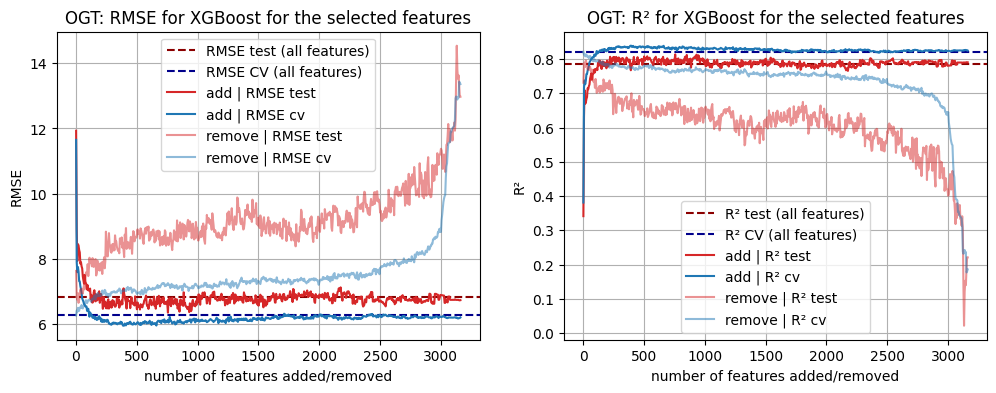

In [36]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.axhline(y=rmse_test, color='darkred', linestyle='--', linewidth=1.5, label='RMSE test (all features)')
plt.axhline(y=rmse_cv, color='darkblue', linestyle='--', linewidth=1.5, label='RMSE CV (all features)')
plt.plot(num_feat_plot, rmse_test_arr_randfor, c = "tab:red", label = "add | RMSE test")
plt.plot(num_feat_plot, rmse_cv_arr_randfor, c = "tab:blue", label = "add | RMSE cv")

plt.plot(num_feat_plot_rem, rmse_test_arr_randfor_rem, c = "tab:red", label = "remove | RMSE test", alpha = 0.5)
plt.plot(num_feat_plot_rem, rmse_cv_arr_randfor_rem, c = "tab:blue", label = "remove | RMSE cv", alpha = 0.5)

plt.xlabel("number of features added/removed")
plt.ylabel("RMSE")
plt.title("OGT: RMSE for XGBoost for the selected features")
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.axhline(y=r2_test, color='darkred', linestyle='--', linewidth=1.5, label='R² test (all features)')
plt.axhline(y=r2_cv, color='darkblue', linestyle='--', linewidth=1.5, label='R² CV (all features)')
plt.plot(num_feat_plot, r2_test_arr_randfor, c = "tab:red", label = "add | R² test")
plt.plot(num_feat_plot, r2_cv_arr_randfor, c = "tab:blue", label = "add | R² cv")

plt.plot(num_feat_plot_rem, r2_test_arr_randfor_rem, c = "tab:red", label = "remove | R² test", alpha = 0.5)
plt.plot(num_feat_plot_rem, r2_cv_arr_randfor_rem, c = "tab:blue", label = "remove | R² cv", alpha = 0.5)

plt.xlabel("number of features added/removed")
plt.ylabel("R²")
plt.title("OGT: R² for XGBoost for the selected features")
plt.grid()
plt.legend()

plt.show()

#### 2.3. Comparison and feature correlations 

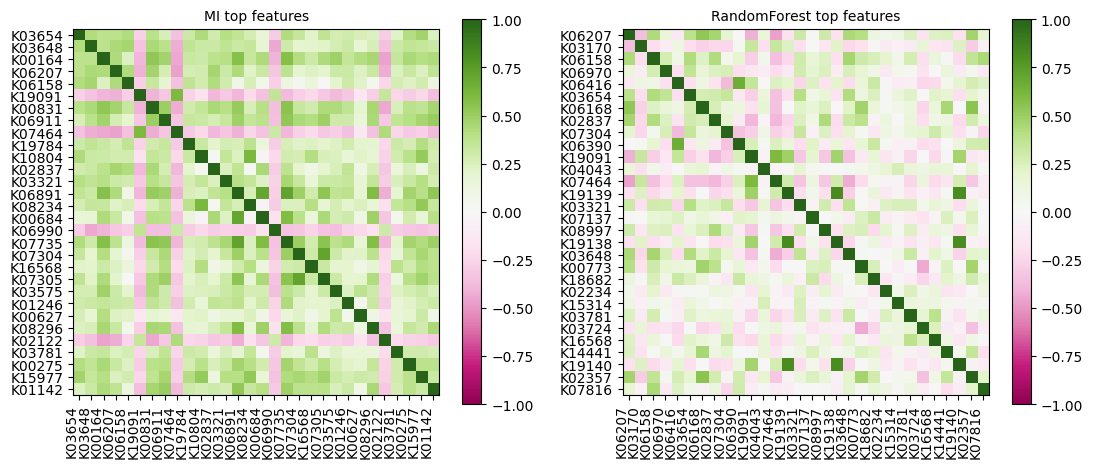

In [24]:
plt.figure(figsize=(13, 5))

vmin, vmax = -1, 1 #-0.6

# Correlation matrix for mean_var top features
plt.subplot(1, 2, 1) 
correlation_matrix = np.corrcoef(top_feat_mi_counts)
plt.imshow(correlation_matrix, vmin=vmin, vmax=vmax, cmap="PiYG")
plt.title("MI top features", fontsize=10)
plt.xticks(ticks=np.arange(len(top_N_names_by_mi)), labels=top_N_names_by_mi, rotation=90, ha="right")
plt.yticks(ticks=np.arange(len(top_N_names_by_mi)), labels=top_N_names_by_mi)
plt.colorbar()

# Correlation matrix for MI top features
plt.subplot(1, 2, 2) 
correlation_matrix = np.corrcoef(top_feat_rand_forest_counts)
plt.imshow(correlation_matrix, vmin=vmin, vmax=vmax, cmap="PiYG")
plt.title("RandomForest top features", fontsize=10)
plt.xticks(ticks=np.arange(len(top_N_names_by_rand_forest)), labels=top_N_names_by_rand_forest, rotation=90, ha="right")
plt.yticks(ticks=np.arange(len(top_N_names_by_rand_forest)), labels=top_N_names_by_rand_forest)
plt.colorbar()

In [25]:
N = 50

select_feat_mi = list(sorted_cog_idx_by_rand_forest[:N])
print(len(select_feat_mi))
X_train_select_feat = X_train[:, select_feat_mi]
print(len(X_train_select_feat[0]))
X_test_select_feat = X_test[:, select_feat_mi]

y_true_cv, y_pred_cv, y_pred_test = train_xgboost(X_train_select_feat, y_train, X_test_select_feat, y_test)
rmse = np.sqrt(mean_squared_error(y_true_cv, y_pred_cv))
r2 = r2_score(y_true_cv, y_pred_cv)

print(rmse)
print(r2)


select_feat_mi = list(sorted_cog_idx_by_rand_forest[N:])
print(len(select_feat_mi))
X_train_select_feat = X_train[:, select_feat_mi]
X_test_select_feat = X_test[:, select_feat_mi]

y_true_cv, y_pred_cv, y_pred_test = train_xgboost(X_train_select_feat, y_train, X_test_select_feat, y_test)
rmse = np.sqrt(mean_squared_error(y_true_cv, y_pred_cv))
r2 = r2_score(y_true_cv, y_pred_cv)

print(rmse)
print(r2)

50
50
6.809866
0.7885763049125671
3115
6.4942374
0.8077205419540405


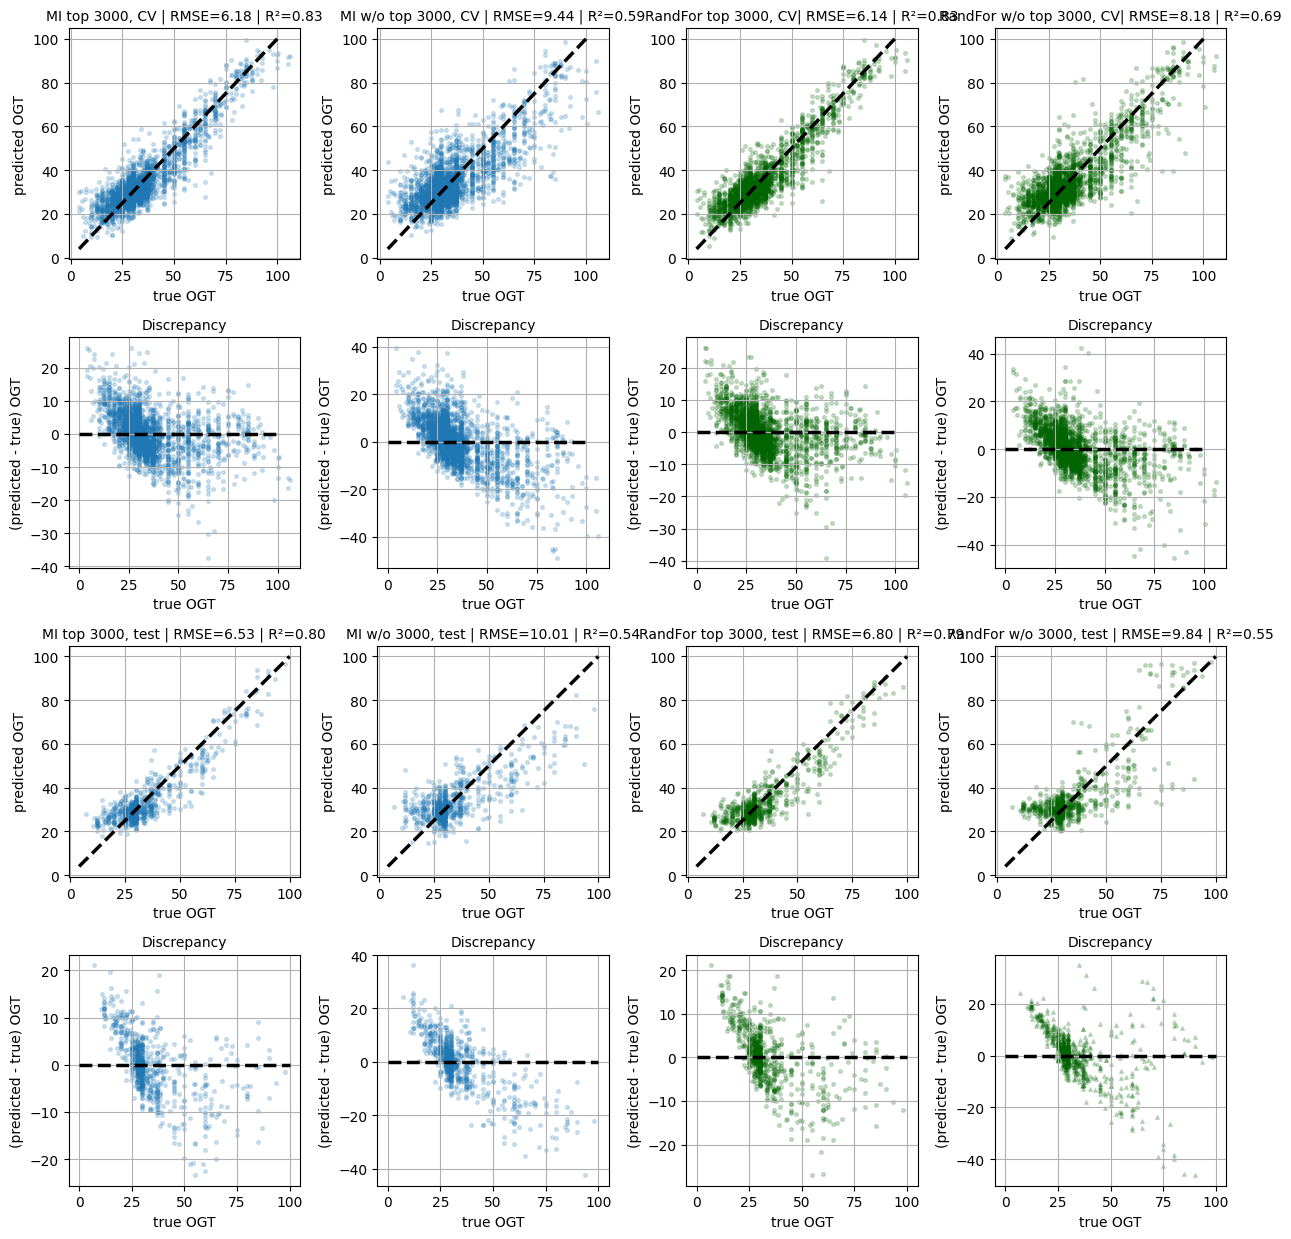

Number of coinciding COGs =  2866, which is 95.53%


In [46]:
# Number of selected features to add/remove from the list of top features
N = 3000
ogt_continuous_flag = True
precence_only_flag = False
X_train, X_train_column_names, y_train, X_test, X_test_column_names, y_test, categories_linspace = read_ogt_data(device, num_classes, ogt_continuous_flag, precence_only_flag)
X_train, y_train, X_test, y_test = X_train.cpu(), y_train.cpu(), X_test.cpu(), y_test.cpu()

plt.figure(figsize=(12.5, 12.5))

# MI top features signal
select_feat_mi = list(sorted_cog_idx_by_mi[:N])
X_train_select_feat = X_train[:, select_feat_mi]
X_test_select_feat = X_test[:, select_feat_mi]

select_feat_mi_rem = list(sorted_cog_idx_by_mi[N:])
X_train_select_feat_rem = X_train[:, select_feat_mi_rem]
X_test_select_feat_rem = X_test[:, select_feat_mi_rem]

# 1: MI top N predict
plt.subplot(4, 4, 1) 
y_true_cv, y_pred_cv, y_pred_test = train_xgboost(X_train_select_feat.cpu(), y_train, X_test_select_feat.cpu(), y_test)
rmse = np.sqrt(mean_squared_error(y_true_cv, y_pred_cv))
r2 = r2_score(y_true_cv, y_pred_cv)
plt.scatter(y_true_cv, y_pred_cv, marker='o', alpha = 0.2, c = "tab:blue", s=7)
plt.plot([4,100],[4,100], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"MI top {N}, CV | RMSE={rmse:.2f} | R²={r2:.2f}", fontsize= 10)
plt.grid(True)

# 5: Diff for MI top N predict
plt.subplot(4, 4, 5) 
diff = [y_pred_cv[i] - y_true_cv[i] for i in range(len(y_true_cv))]
plt.scatter(y_true_cv, diff, marker='o', alpha = 0.2, c = "tab:blue", s=7, facecolor='none')    
plt.plot([0,100],[0,0], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title("Discrepancy", fontsize= 10)
plt.grid(True)

# 9: MI top N predict: test
plt.subplot(4, 4, 9) 
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2 = r2_score(y_test, y_pred_test)
plt.scatter(y_test, y_pred_test, marker='o', alpha = 0.2, c = "tab:blue", s=7)
plt.plot([4,100],[4,100], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"MI top {N}, test | RMSE={rmse:.2f} | R²={r2:.2f}", fontsize= 10)
plt.grid(True)

# 13: Diff for MI top N predict
plt.subplot(4, 4, 13) 
diff = [y_pred_test[i] - y_test[i] for i in range(len(y_test))]
plt.scatter(y_test, diff, marker='o', alpha = 0.2, c = "tab:blue", s=7, facecolor='none')    
plt.plot([0,100],[0,0], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title("Discrepancy", fontsize= 10)
plt.grid(True)

# 2: MI w/o top N predict
plt.subplot(4, 4, 2) 
y_true_cv, y_pred_cv, y_pred_test = train_xgboost(X_train_select_feat_rem.cpu(), y_train, X_test_select_feat_rem.cpu(), y_test)
rmse = np.sqrt(mean_squared_error(y_true_cv, y_pred_cv))
r2 = r2_score(y_true_cv, y_pred_cv)
plt.scatter(y_true_cv, y_pred_cv, marker='o', alpha = 0.2, c = "tab:blue", s=7)
plt.plot([4,100],[4,100], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"MI w/o top {N}, CV | RMSE={rmse:.2f} | R²={r2:.2f}", fontsize= 10)
plt.grid(True)

# 6: Diff for MI w/o top N predict
plt.subplot(4, 4, 6) 
diff = [y_pred_cv[i] - y_true_cv[i] for i in range(len(y_true_cv))]
plt.scatter(y_true_cv, diff, marker='o', alpha = 0.2, c = "tab:blue", s=7, facecolor='none')    
plt.plot([0,100],[0,0], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title("Discrepancy", fontsize= 10)
plt.grid(True)

# 10: MI w/o N predict: test
plt.subplot(4, 4, 10) 
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2 = r2_score(y_test, y_pred_test)
plt.scatter(y_test, y_pred_test, marker='o', alpha = 0.2, c = "tab:blue", s=7)
plt.plot([4,100],[4,100], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"MI w/o {N}, test | RMSE={rmse:.2f} | R²={r2:.2f}", fontsize= 10)
plt.grid(True)

# 14: Diff for MI top N predict
plt.subplot(4, 4, 14) 
diff = [y_pred_test[i] - y_test[i] for i in range(len(y_test))]
plt.scatter(y_test, diff, marker='o', alpha = 0.2, c = "tab:blue", s=7, facecolor='none')    
plt.plot([0,100],[0,0], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title("Discrepancy", fontsize= 10)
plt.grid(True)

# RandomForest only signal
select_feat_ranfor = list(sorted_cog_idx_by_rand_forest[:N])
X_train_select_feat = X_train[:, select_feat_ranfor]
X_test_select_feat = X_test[:, select_feat_ranfor]

select_feat_ranfor_rem = list(sorted_cog_idx_by_rand_forest[N:])
X_train_select_feat_rem = X_train[:, select_feat_ranfor_rem]
X_test_select_feat_rem = X_test[:, select_feat_ranfor_rem]

#3: RandomForest top N predict
plt.subplot(4, 4, 3) 
y_true_cv, y_pred_cv, y_pred_test = train_xgboost(X_train_select_feat.cpu(), y_train, X_test_select_feat.cpu(), y_test)
rmse = np.sqrt(mean_squared_error(y_true_cv, y_pred_cv))
r2 = r2_score(y_true_cv, y_pred_cv)
plt.scatter(y_true_cv, y_pred_cv, marker='o', alpha = 0.2, c = "darkgreen", s=7)
plt.plot([4,100],[4,100], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"RandFor top {N}, CV| RMSE={rmse:.2f} | R²={r2:.2f}", fontsize= 10)
plt.grid(True)

#7: Diff RandomForest top N predict
plt.subplot(4, 4, 7) 
diff = [y_pred_cv[i] - y_true_cv[i] for i in range(len(y_true_cv))]
plt.scatter(y_true_cv, diff, marker='o', alpha = 0.2, c = "darkgreen", s=7, facecolor='none')    
plt.plot([0,100],[0,0], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title("Discrepancy", fontsize= 10)
plt.grid(True)

# 11: RandomForest top N predict: test
plt.subplot(4, 4, 11) 
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2 = r2_score(y_test, y_pred_test)
plt.scatter(y_test, y_pred_test, marker='o', alpha = 0.2, c = "darkgreen", s=7)
plt.plot([4,100],[4,100], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"RandFor top {N}, test | RMSE={rmse:.2f} | R²={r2:.2f}", fontsize= 10)
plt.grid(True)

# 15: Diff for RandomForest top N predict
plt.subplot(4, 4, 15) 
diff = [y_pred_test[i] - y_test[i] for i in range(len(y_test))]
plt.scatter(y_test, diff, marker='o', alpha = 0.2, c = "darkgreen", s=7, facecolor='none')    
plt.plot([0,100],[0,0], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title("Discrepancy", fontsize= 10)
plt.grid(True)

#4: RandomForest w/o top N predict
plt.subplot(4, 4, 4) 
y_true_cv, y_pred_cv, y_pred_test = train_xgboost(X_train_select_feat_rem.cpu(), y_train, X_test_select_feat_rem.cpu(), y_test)
rmse = np.sqrt(mean_squared_error(y_true_cv, y_pred_cv))
r2 = r2_score(y_true_cv, y_pred_cv)
plt.scatter(y_true_cv, y_pred_cv, marker='o', alpha = 0.2, c = "darkgreen", s=7)
plt.plot([4,100],[4,100], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"RandFor w/o top {N}, CV| RMSE={rmse:.2f} | R²={r2:.2f}", fontsize= 10)
plt.grid(True)

#8: Diff RandomForest w/o top N predict
plt.subplot(4, 4, 8) 
diff = [y_pred_cv[i] - y_true_cv[i] for i in range(len(y_true_cv))]
plt.scatter(y_true_cv, diff, marker='o', alpha = 0.2, c = "darkgreen", s=7, facecolor='none')    
plt.plot([0,100],[0,0], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title("Discrepancy", fontsize= 10)
plt.grid(True)

# 12: RandomForest top N predict: test
plt.subplot(4, 4, 12) 
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2 = r2_score(y_test, y_pred_test)
plt.scatter(y_test, y_pred_test, marker='o', alpha = 0.2, c = "darkgreen", s=7)
plt.plot([4,100],[4,100], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"RandFor w/o {N}, test | RMSE={rmse:.2f} | R²={r2:.2f}", fontsize= 10)
plt.grid(True)

# 16: Diff for RandomForest w/o top N predict
plt.subplot(4, 4, 16) 
diff = [y_pred_test[i] - y_test[i] for i in range(len(y_test))]
plt.scatter(y_test, diff, marker='^', alpha = 0.2, c = "darkgreen", s=7, facecolor='none')    
plt.plot([0,100],[0,0], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title("Discrepancy", fontsize= 10)
plt.grid(True)

# Display the plots
plt.tight_layout()  
plt.show()

num_coinc = len(set(select_feat_mi) & set(select_feat_ranfor))
print(f"Number of coinciding COGs =  {num_coinc}, which is {round(100*num_coinc/N,2)}%")

#### 2.4. SHAP values

### TODO: move the fun to utils (or remove)

In [1]:
import pandas as pd
import numpy as np
import torch

In [2]:
train_filename = "../data_ogt/kegg_train.csv"
test_filename = "../data_ogt/kegg_test.csv"
ogt_label_filename = "../data_ogt/ogt_splits.csv"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def read_ogt_data_custom_split(train_filename, test_filename, ogt_label_filename, device, precence_only_flag=False):
    df_train = pd.read_csv(train_filename, sep="\t")
    df_train.fillna(0, inplace=True)
    
    df_test = pd.read_csv(test_filename, sep="\t")
    df_test.fillna(0, inplace=True)
    
    df_labels = pd.read_csv(ogt_label_filename, sep=",")
    df_labels.rename(columns={'acc': 'accession'}, inplace=True)
    df_labels = df_labels.drop(columns=['min','max','ogt_split', 'min_split', 'max_split'])


    merged_df_train = pd.merge(df_train, df_labels, on='accession', how='inner')
    y_train = merged_df_train["ogt"].values
    y_train = torch.tensor(y_train).to(device)
    y_train = y_train.float()

   # print(y_train)

    merged_df_train = merged_df_train.drop(columns=['accession','ogt'])
    X_train_column_names = merged_df_train.columns
    X_train = torch.tensor(merged_df_train.values)
    X_train = X_train.float().to(device)
    X_train_numpy = X_train.cpu().numpy()
    if precence_only_flag == True:
        X_train_numpy = (X_train_numpy > 0).astype(int)
    X_train = torch.tensor(X_train_numpy, dtype=torch.float32).to(device)

    merged_df_test = pd.merge(df_test, df_labels, on='accession', how='inner')
    y_test = merged_df_test["ogt"].values
    y_test = torch.tensor(y_test).to(device)
    y_test = y_test.float()

    #print(y_test)

    merged_df_test = merged_df_test.drop(columns=['accession','ogt'])
    X_test_column_names = merged_df_test.columns
    X_test = torch.tensor(merged_df_test.values)
    X_test = X_test.float().to(device)
    X_test_numpy = X_test.cpu().numpy()
    if precence_only_flag == True:
        X_test_numpy = (X_test_numpy > 0).astype(int)
    X_test = torch.tensor(X_test_numpy, dtype=torch.float32).to(device)
    
    return X_train, X_train_column_names, y_train, X_test, X_test_column_names, y_test

In [ ]:
precence_only_flag = False
X_train, X_train_column_names, y_train, X_test, X_test_column_names, y_test = read_ogt_data_custom_split(train_filename, test_filename, ogt_label_filename, device, precence_only_flag)


## SHAP values

In [71]:
import shap
import numpy as np
from xgboost import XGBRegressor

precence_only_flag = False
X_train, X_train_column_names, y_train, X_test, X_test_column_names, y_test, categories_linspace = read_ogt_data(device, num_classes, ogt_continuous_flag, precence_only_flag)
X_train, y_train, X_test, y_test = X_train.cpu(), y_train.cpu(), X_test.cpu(), y_test.cpu()


# Train your model
model = XGBRegressor(
    n_jobs=-1,                # Use all CPU cores
    tree_method="hist",   # Use "hist" for CPU, "gpu_hist" for GPU
    objective="reg:squarederror",  # Default loss function for regression
    )
model.fit(X_train,y_train);

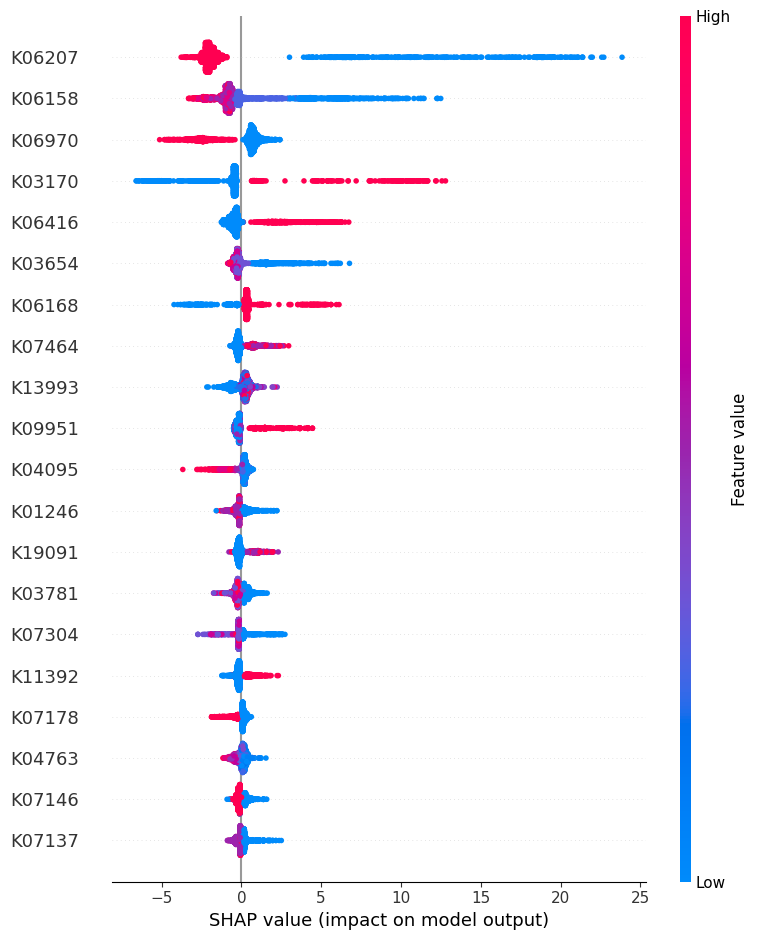

In [72]:
# Create SHAP Explainer
explainer = shap.TreeExplainer(model)

# Compute SHAP values for training & test set
shap_values_train = explainer.shap_values(X_train)
shap_values_test = explainer.shap_values(X_test)

# Visualize feature importance
shap.summary_plot(shap_values_train, X_train, feature_names=X_train_column_names)  # Summary plot

In [74]:
shap_df = pd.DataFrame(shap_values_train, columns=[f"Feature_{i}" for i in range(X_train.shape[1])])
# Print SHAP values
matrix = shap_df.values
print(shap_df.values)

average_shaps = np.mean(shap_values_train, axis=0)

average_shaps_df = pd.DataFrame(average_shaps, columns=["Average SHAP Value"], index=X_train_column_names)

# Display the average SHAP values
print(average_shaps_df)

[[-0.02407274 -0.00101798 -0.00014091 ...  0.          0.
   0.        ]
 [ 0.01016061 -0.00161858 -0.05036938 ...  0.          0.
   0.        ]
 [-0.06214902  0.01269251  0.00067772 ...  0.          0.
   0.        ]
 ...
 [-0.02574561  0.00045797 -0.00086367 ...  0.          0.
   0.        ]
 [-0.01978016  0.0074421  -0.00070356 ...  0.          0.
   0.        ]
 [-0.02516385  0.00056147 -0.00618937 ...  0.          0.
   0.        ]]
        Average SHAP Value
K07461           -0.003820
K00243            0.001333
K00185           -0.001812
K01890            0.000524
K00406           -0.005450
...                    ...
K21418            0.000000
K12260           -0.000022
K19949            0.000000
K18134            0.000000
K14326            0.000000

[3165 rows x 1 columns]


Text(0.5, 1.0, 'OGT: average SHAP value for the top 50 features')

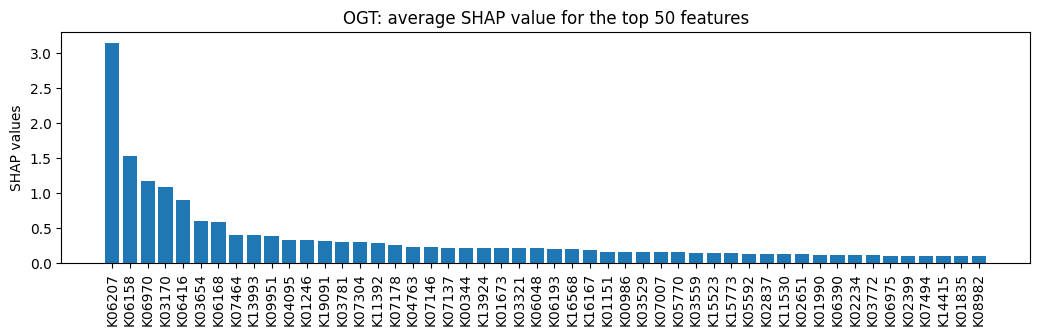

In [88]:
# Extracting top N 
N=50
abs_shap_values = np.abs(shap_values_train)

# Step 2: Calculate the mean absolute SHAP value for each feature across all samples
mean_abs_shap_values = np.mean(abs_shap_values, axis=0)

# Step 3: Sort the features based on the mean absolute SHAP values
sorted_indices = np.argsort(mean_abs_shap_values)[::-1]  # Sorting in descending order
sorted_feature_names = [X_train_column_names[i] for i in sorted_indices]

top_n_features = [f"{i}" for i in sorted_feature_names[:N]]

# Step 6: Display the top N features and their average SHAP values
top_n_shap_values = mean_abs_shap_values[sorted_indices[:N]]
top_n_df = pd.DataFrame({
    'Feature': top_n_features,
    'Average SHAP Value': top_n_shap_values
})

plt.figure(figsize=(12.5, 3))
plt.bar(range(len(top_n_shap_values)),top_n_shap_values)
plt.xticks(range(len(top_n_features)), top_n_features, rotation=90);
plt.ylabel("SHAP values")
plt.title(f"OGT: average SHAP value for the top {N} features")

In [86]:
import pandas as pd



# Define the data for the columns
data = {
    'MI': top_N_names_by_mi,
    'RandomForest': top_N_names_by_rand_forest,
    'SHAP': top_n_features[:len(top_N_names_by_mi)],
}

# Create DataFrame with specified column names
df = pd.DataFrame(data)

# Print the DataFrame
display(df)

,MI,RandomForest,SHAP
0,K03654,K06207,K06207
1,K03648,K03170,K06158
2,K00164,K06158,K06970
3,K06207,K06970,K03170
4,K06158,K06416,K06416
5,K19091,K03654,K03654
6,K00831,K06168,K06168
7,K06911,K02837,K07464
8,K07464,K07304,K13993
9,K19784,K06390,K09951
